<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

# AC SAF - Near-real time (NRT) and Offline (Level 2) products

AC SAF Level 2 data products are available as `near-real time (NRT)` and `offline`. NRT data products are available within three hours from sensing for the past two months. Offline products are available within 15 days from sensing at latest, but typical is a delay of 2-3 days.  AC SAF Level 2 data are disseminated in `HDF5` data format.

### Load required libraries

In [344]:
import os
import h5py
from netCDF4 import Dataset, MFDataset
import xarray as xr
import numpy as np
import pandas
import datetime

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from ipyleaflet import Map, basemaps, TileLayer, FullScreenControl, Marker
import cartopy

from IPython.display import display, clear_output

In [343]:
os.chdir('/Users/julia_wagemann/Documents/github/ltpy/sample_data/level2_case_studies/2019_amazonas_fires/')

<hr>

## Load and browse AC SAF Level 2 products

[h5py](http://docs.h5py.org/en/stable/) is a Python library that let's you access and manipulate data sets in HDF5 data format.

### Structure of AC SAF Level 2 product data files

The data in the HDF5 file is organized in five groups:
* META_DATA
 * Product Metadata
* GEOLOCATION
 * Date & Time (all retrievals)
 * 4 Corner Coordinates & Centre of Ground Pixel
 * Solar, Line-of-Sight Zenith, and realtive Azimuth angles at TOA
 * Orbit information
* TOTAL_COLUMNS
 * Total and tropospheric column amounts of the various trace gases with corresponding (relative) errors
* DETAILED_RESULTS
 * Geophysical parameters (surface, cloud and aerosol values)
 * Vertical column, slant column, and AMF values with corresponding errors
 * Fittings diagnostics (chi-square, RMS, etc.)
 * Various subgroups for trace gas specific data (e.g. O<sub>3</sub>, NO<sub>2</sub>, SO<sub>2</sub>, etc.)
* CLOUD_PROPERTIES
 * Retrieve cloud properties

<br>

### Load HDF5 data with h5py

A HDF5 file can be openend with the `File` function of the h5py package. The read attribute `r` gives read permission, but does not overwrite the original data file. The file object acts like a Python dictionary. Thus, the `keys` function allows us to see the different groups the file contains.

In [345]:
file = h5py.File('./gome2a/20190818/S-O3M_GOME_O3-NO2-NO2Tropo-SO2-HCHO_L2_20190818210555_003_METOPA_66576_DLR_04.HDF5', 'r')
groups = sorted(file.keys())
groups

['CLOUD_PROPERTIES',
 'DETAILED_RESULTS',
 'GEOLOCATION',
 'META_DATA',
 'TOTAL_COLUMNS']

<br>

Each group contains multiple variables. We can print out all variables of each group nicely formatted. This gives us a helpful overview of available parameters. We are mostly interested in parameters of the `GEOLOCATION` and `TOTAL_COLUMNS` groups.

We see that one AC SAF Level 2 data file contains trace gas total columns of six parameters:
* `BrO` - Hypobromite
* `H`<sub>`2`</sub>`O` - Water vapour
* `HCHO` - Formaldehyde
* `NO`<sub>`2`</sub> - Nitrogen Dioxide
* `O`<sub>`3`</sub> - Ozone
* `SO`<sub>`2`</sub> - Sulfur Dioxide

Additionally, the data file contains the tropospheric vertical column of Nitrogen Dioxide:
* `NO`<sub>`2`</sub> `Tropo` - Tropospheric Nitrogen Dioxide

In [279]:
 for group in groups:
    print('{}:'.format(group))
    # variables in a group
    variables = sorted(file[group].keys())
    # pretty print of variables in 3 columns
    for v1, v2, v3 in zip(variables[::3], variables[1::3], variables[2::3]):
        print('   - {:<30}- {:<30}- {:<}'.format(v1, v2, v3))
    if (len(variables) % 3) == 1:
        print('   - {:<30}'.format(variables[-1]))
    elif (len(variables) % 3) == 2:
        print('   - {:<30}- {:<}'.format(*variables[-2:]))
    # white line between one line and another
    print()

CLOUD_PROPERTIES:
   - CloudFraction                 - CloudFraction_Error           - CloudMode
   - CloudOpticalThickness         - CloudOpticalThickness_Error   - CloudTopAlbedo
   - CloudTopAlbedo_Error          - CloudTopHeight                - CloudTopHeight_Error
   - CloudTopPressure              - CloudTopPressure_Error        - CloudType
   - PMDCloudFraction              

DETAILED_RESULTS:
   - AAI                           - AMFToCloudTop                 - AMFToCloudTop_Error
   - AMFToGround                   - AMFToGround_Error             - AMFTotal
   - AMFTotal_Error                - Clouds                        - ESC
   - ESC_Error                     - FittingChiSquare              - FittingGoodness
   - FittingNumberOfIterations     - FittingRMS                    - HCHO
   - IntensityWeightedCloudFraction- NO2                           - O3
   - QualityFlags                  - SO2                           - SurfaceAlbedo
   - SurfaceConditionFlags         - Surf

### Select and retrieve one specific parameter from a HDF5 file group

Let's say, we are interested in the Total vertical column density of Nitrogen-Dioxide (NO<sub>2</sub>). We can retrieve the parameter values by selecting the internal path of the data file: `TOTAL_COLUMNS/NO2`. The resulting object is a HDF5 dataset, which has a shape of a 1-dimensional vector.

In [280]:
no2 = file['TOTAL_COLUMNS/NO2']
no2

<HDF5 dataset "NO2": shape (959,), type "<f4">

<br>

Attributes of the NO<sub>2</sub> object can be accessed with the `attrs` function. Atrributes are  helpful to better understand the parameter, e.g. we get information about minimum and maximum values of the parameter and the unit of the data values.

In [281]:
dict(no2.attrs)

{'Unit': array([b'mol/cm2'], dtype='|S7'),
 'Title': array([b'Initial total vertical column density of NO2'], dtype='|S44'),
 'FillValue': array([-1.], dtype=float32),
 'CheckSum': array([850156515], dtype=int32),
 'ValueRangeMin': array([3.036268e+14], dtype=float32),
 'ValueRangeMax': array([2.860005e+15], dtype=float32)}

<br>

Data values can be accessed with the `value` function, which returns the data values as a numpy array.

In [282]:
no2.value

array([1.661598e+15, 1.731493e+15, 1.222206e+15, ..., 1.491321e+15,
       2.401488e+15, 1.858305e+15], dtype=float32)

<br>

## Build a xarray `DataArray` object for a AC SAF Level 2 parameter

For easier handling and plotting of the parameters, we combine geolocation information and data values in a xarray `DataArray` structure, which can be created with the xarray `DataArray` constructor. 

The constructor takes:
* `data`: an array of values (can be e.g. a numpy ndarray, but also a `Series`, `DataFrame` or `Panel`)
* `dims`: a list of dimension names
* `coords`: a list or dictionary of coordinates
* `attrs`: a dictionary of attributes to add to the instance

We take the centre of the ground pixel as coordinates of the `DataArray`. The values can be retrieved from the internal paths `GEOLOCATION/LatitudeCentre` and `GEOLOCATION/LongitudeCentre` respectively.

The resulting object is a xarray `DataArray` instance with latitude and longitude information and the NO<sub>2</sub> values as data values. The `DataArray` object contains around 15 000 ground pixels.

In [283]:
latitude = file['GEOLOCATION/LatitudeCentre']
longitude = file['GEOLOCATION/LongitudeCentre']

no2_da = xr.DataArray(
    no2.value,
    dims=('ground_pixel'),
    coords={
        'latitude': ('ground_pixel', latitude[:]),
        'longitude': ('ground_pixel', longitude[:])
    },
    attrs={'long_name': 'Vertical column density of NO2', 'units': 'mol/cm2'},
    name='vertical_column_NO2'
)

no2_da

<xarray.DataArray 'vertical_column_NO2' (ground_pixel: 959)>
array([1.661598e+15, 1.731493e+15, 1.222206e+15, ..., 1.491321e+15,
       2.401488e+15, 1.858305e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 -28.684595 -28.669733 ... -39.125088
    longitude  (ground_pixel) float32 175.76765 175.63272 ... 172.66959
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

### Plotting example of AC SAF Level 2 products - Single file with `PlateCarree` projection

We can continue to plot (visualize) the `DataArray` object. Python provides several plotting libraries. One extensive plotting library is [matplotlib](https://matplotlib.org/).

[Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is another useful Python package. Key features of `cartopy` are its object-oriented [projection definitions](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html), and its ability to transform points, lines, vectors, polygons and images between those projections. Cartopy includes a programmatic interface built on top of Matplotlib for the creation of publication quality maps.

As basemap, we create a map in a `PlateCarree` projection. We add coast- and gridlines. On top of the basemap, we plot the NO<sub>2</sub> values as a scatter plot, with the `scatter` function. As we might need to reuse the code for plotting, we define a plotting function called `visualize_gome_l2`.

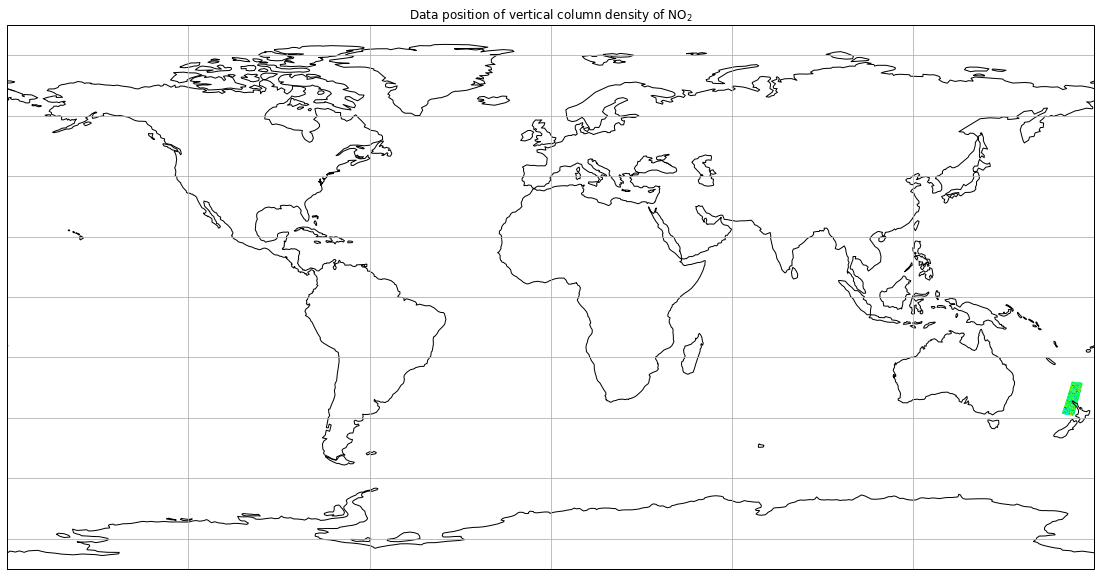

In [335]:
def visualize_gome_l2(xr_dataarray, projection):
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=projection)

    ax.coastlines()
    ax.set_global()

    # set gridlines
    ax.gridlines()

    # plot O3 pixel positions
    ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*1e-15,
        cmap=plt.cm.get_cmap('gist_rainbow_r'),
        marker='o',
        s=0.5,
        transform=ccrs.PlateCarree()
    )

    ax.set_title(r'Data position of vertical column density of NO$_2$')
    plt.show()

visualize_gome_l2(no2_da, ccrs.PlateCarree())

The example above shows that one individual file contains the data for only one ground track. If we want to see all the data that has been sensed on one individual day, we have to combine multiple HDF5 files.

<br>

## Combine multiple HDF5 files in a xarray `DataArray` object

AC SAF Level 2 data files for one individual day are stored in multiple files. In order to combine all sensed ground tracks for one individual day, we can combine the steps above in a for loop:

* 1) Open the HDF5 file with `h5py.File` <br>
* 2) Retrieve information on `GEOLOCATION` and the `TOTAL_COLUMNS` parameter of interest
* 3) Generate a xarray `DataArray` and store it in a list of DataArrays
* 4) Concatenate the the DataArrays into one `DataArray` with `xarray.concat`

The result is a 1-dimensional `DataArray` containing the ground pixels of all GOME-2A files for one specific day. We see that the `DataArray` object contains now over 190 000 ground pixels.

In [346]:
fileList = os.listdir('./')
datasets = []

for i in fileList:
    tmp = h5py.File(i, 'r')
    groups =tmp.keys()
    tmp['TOTAL_COLUMNS/']
    latitude = tmp['GEOLOCATION/LatitudeCentre']
    longitude = tmp['GEOLOCATION/LongitudeCentre']
    no2 = tmp['TOTAL_COLUMNS/NO2']
    da_tmp = xr.DataArray(
        no2.value,
        dims=('ground_pixel'),
        coords={
            'latitude': ('ground_pixel', latitude[:]),
            'longitude': ('ground_pixel', longitude[:])
        },
        attrs={'long_name': 'Vertical column density of NO2', 'units': 'mol/cm2'},
        name='vertical_column_NO2'
    )
    datasets.append(da_tmp)

no2_a_da_mf = xr.concat(datasets, dim='ground_pixel')

no2_a_da_mf[no2_a_da_mf < 0] = 0

KeyError: "Unable to open object (object 'TOTAL_COLUMNS' doesn't exist)"

<br>

### Plotting example of AC SAF Level 2 products - Multiple files with `Mollweide` projection

The plotting example above showed that the `PlateCarree` projection is not the best suited projection for representing the GOME-2 ground tracks. Thus, all ground tracks of one day, we want to visualize in `Mollweide` projection. We change our basemap to the `Mollweide` projection and add a transform argument to our scatter plot, in order to transform our coordinates to a `Mollweide` projection.

As we defined the function `visualize_gome_l2` to visualize the data, we can simply call the function and just specify the different projection.

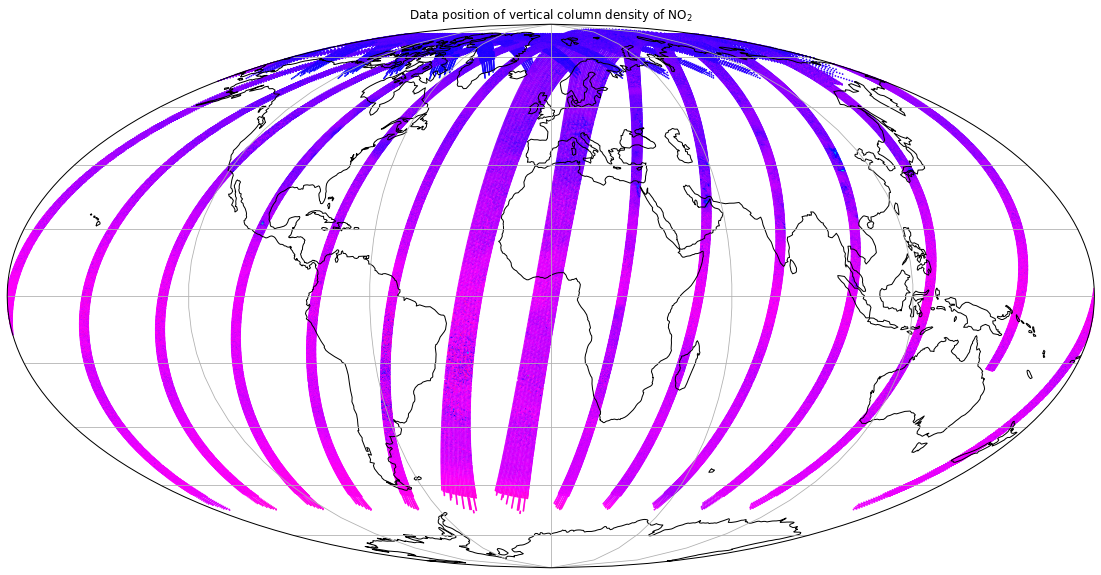

In [336]:
visualize_gome_l2(no2_a_da_mf, ccrs.Mollweide())

<br>

## Combine Metop-A and Metop-B data files

The above examples show that Metop-A data have many parts on Earth unsensed. Metop-A data can be combined with Metop-B ground pixel for one specific day in order to increase the overall coverage. Metop-B has a wider nominal resolution than Metop-A.

Since we already concatenated the ground pixel values for day 18 Aug 2019 for Metop-A GOME Level 2 data, we only have to do the same for the Metop-B data files. The defined visualization function `visualize_gome_l2` makes it very easy to quickly have a look at the concatenated data from Metop-B.

In [338]:
os.chdir('../../gome2b/20190818/')
fileList = os.listdir('./')
datasets = []

for i in fileList:
    tmp = h5py.File(i, 'r')
    groups =tmp.keys()
    tmp['TOTAL_COLUMNS/']
    latitude = tmp['GEOLOCATION/LatitudeCentre']
    longitude = tmp['GEOLOCATION/LongitudeCentre']
    no2 = tmp['TOTAL_COLUMNS/NO2']
    da_tmp = xr.DataArray(
        no2.value,
        dims=('ground_pixel'),
        coords={
            'latitude': ('ground_pixel', latitude[:]),
            'longitude': ('ground_pixel', longitude[:])
        },
        attrs={'long_name': 'Vertical column density of NO2', 'units': 'mol/cm2'},
        name='vertical_column_NO2'
    )
    datasets.append(da_tmp)

no2_b_da_mf = xr.concat(datasets, dim='ground_pixel')
no2_b_da_mf[no2_b_da_mf < 0] = 0

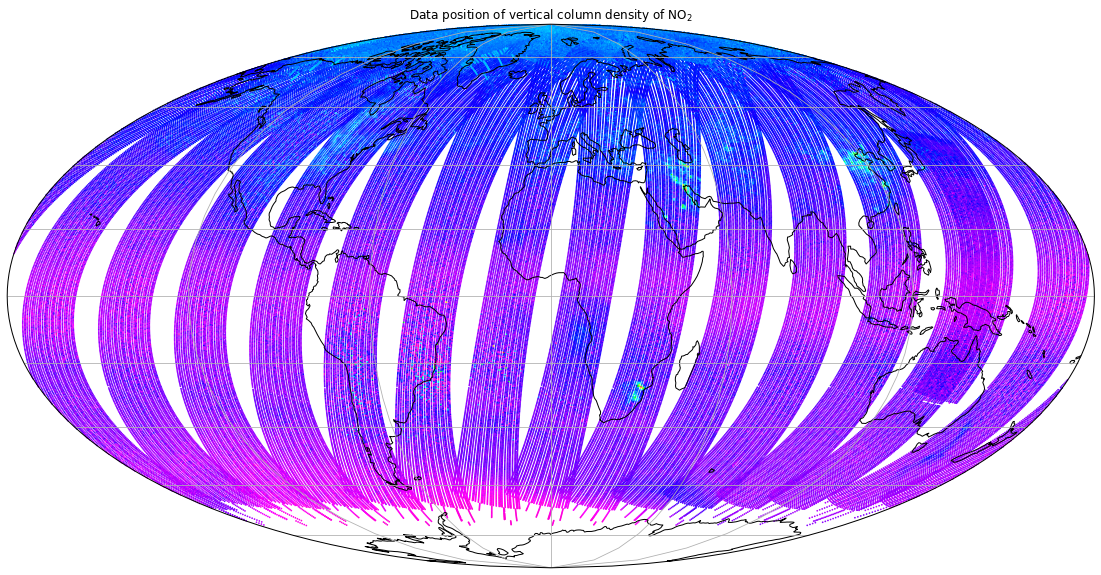

In [339]:
visualize_gome_l2(no2_b_da_mf, ccrs.Mollweide())

<br>

To combine data from Metop-A and Metop-B, we have to concatenate both `DataArrays` with `xarray.concat`. The resulting `DataArray` object has more than 430 000 ground pixel values. With the `visualize_gome_l2` function, we can visualize the combined values as well.

In [340]:
no2_ab_da_mf = xr.concat([no2_a_da_mf, no2_b_da_mf], dim='ground_pixel')
no2_ab_da_mf

<xarray.DataArray 'vertical_column_NO2' (ground_pixel: 430061)>
array([2.689924e+15, 2.223991e+15, 2.838269e+15, ..., 1.738386e+15,
       1.393659e+15, 1.725905e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 26.470398 26.550468 ... 12.834981
    longitude  (ground_pixel) float32 343.80017 343.42032 ... 147.40855
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of NO2
    units:      mol/cm2

<br>

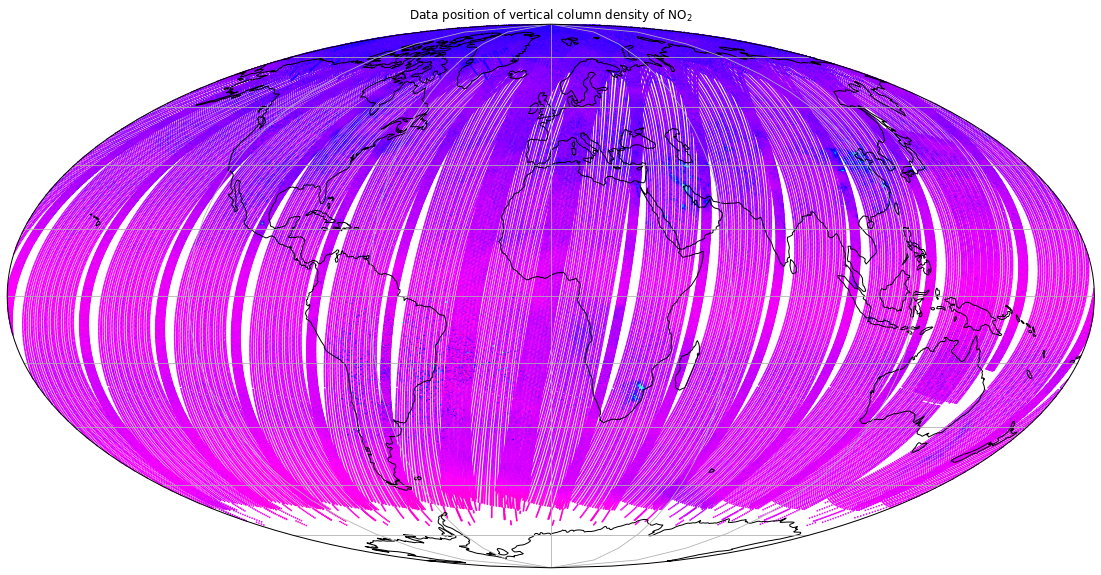

In [342]:
visualize_gome_l2(no2_ab_da_mf, ccrs.Mollweide())

<br>

<hr>

<p style="text-align:left;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/blob/master/LICENSE">&copy; Copyright 2019 eo-lab</a> <span style="float:right;">View on GitLab | Cite | Contact</span></p>